# Model Training and Feature Importance Analysis

This notebook trains a Random Forest model on the processed molecular data and analyzes which features are most important for predicting flashpoint values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Load processed data
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")

Training data shape: (11756, 15)
Test data shape: (2940, 15)
Features: ['is_silicon', 'is_metallic', 'is_tin', 'is_acid', 'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 'NumAromaticRings', 'TPSA', 'data_type_randonly selected as training point or test point', 'data_type_test data', 'data_type_training data', 'source_encoded']


In [4]:
# Train Random Forest model
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=200,          
    max_depth=15,              
    min_samples_split=5,        
    min_samples_leaf=2,         
    random_state=42,
    n_jobs=-1                   
)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)



print("Model training completed!")

Training Random Forest Regressor...
Model training completed!
Model training completed!


In [5]:
# Evaluate model performance
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# Evaluate on both training and test sets
train_metrics = evaluate_model(y_train, y_train_pred, "Training Set")
test_metrics = evaluate_model(y_test, y_test_pred, "Test Set")

# Calculate overfitting indicator
print(f"\nOverfitting Analysis:")
print(f"  Training R²: {train_metrics['R2']:.4f}")
print(f"  Test R²:     {test_metrics['R2']:.4f}")
print(f"  Difference:  {train_metrics['R2'] - test_metrics['R2']:.4f}")


Training Set Performance:
  RMSE: 17.1081
  MAE:  9.5435
  R²:   0.9434

Test Set Performance:
  RMSE: 28.9949
  MAE:  15.9884
  R²:   0.8415

Overfitting Analysis:
  Training R²: 0.9434
  Test R²:     0.8415
  Difference:  0.1019


**Overall** the model performs well. The difference of R² (accuracy-like metric) between the training set predictions and test set predictions is relatively low.

# Feature Importance Analysis

We need analyze which features are most important for predicting flashpoint values using both built-in Random Forest feature importance and permutation importance.Then we test the performance of the model using the "important" features.

This feature selection may reduce overfitting and make the model less sensible to noise.

Top 15 Most Important Features (Random Forest Built-in):
                                              feature  importance
4                                               MolWt    0.454637
10                                               TPSA    0.234309
9                                    NumAromaticRings    0.137808
5                                                LogP    0.073745
1                                         is_metallic    0.022167
8                                   NumRotatableBonds    0.021522
7                                       NumHAcceptors    0.016767
6                                          NumHDonors    0.015865
14                                     source_encoded    0.014845
0                                          is_silicon    0.005230
3                                             is_acid    0.002037
2                                              is_tin    0.000628
11  data_type_randonly selected as training point ...    0.000215
13                 

Top 15 Most Important Features (Random Forest Built-in):
                                              feature  importance
4                                               MolWt    0.454637
10                                               TPSA    0.234309
9                                    NumAromaticRings    0.137808
5                                                LogP    0.073745
1                                         is_metallic    0.022167
8                                   NumRotatableBonds    0.021522
7                                       NumHAcceptors    0.016767
6                                          NumHDonors    0.015865
14                                     source_encoded    0.014845
0                                          is_silicon    0.005230
3                                             is_acid    0.002037
2                                              is_tin    0.000628
11  data_type_randonly selected as training point ...    0.000215
13                 

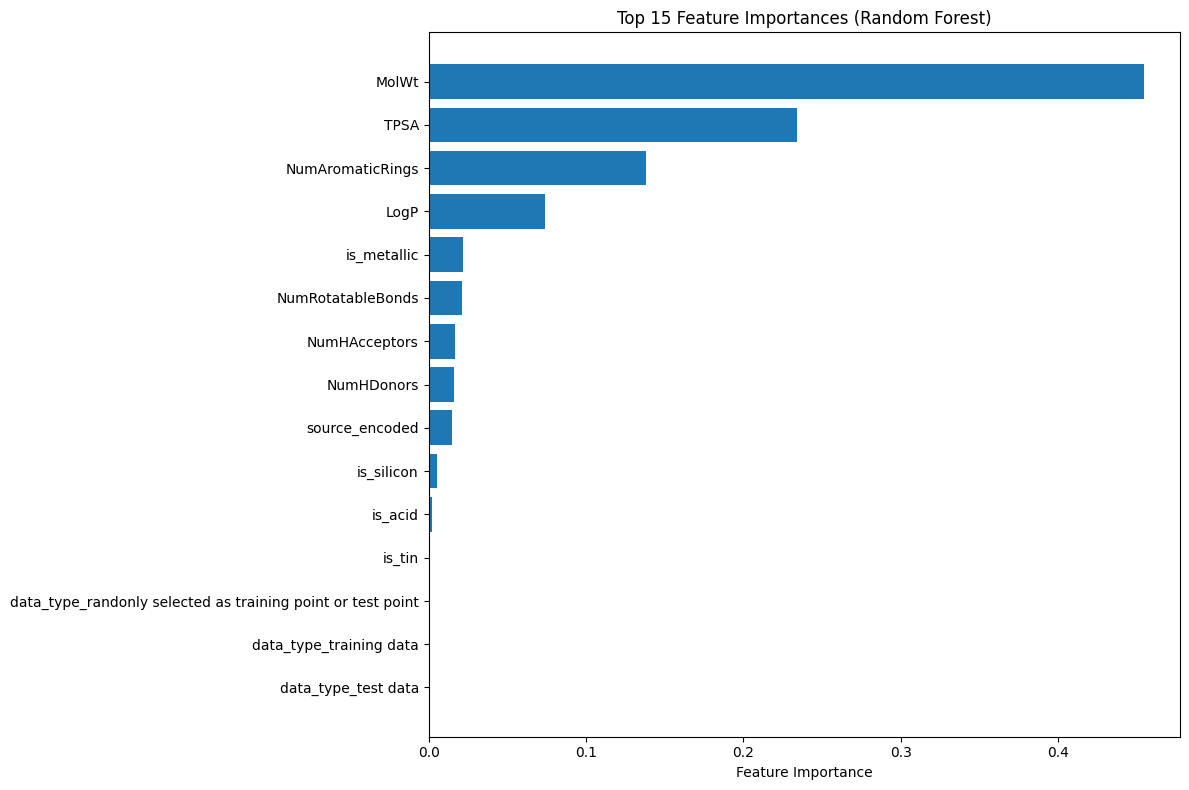

In [6]:
# Feature Importance Analysis - Method 1: Built-in Random Forest Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features (Random Forest Built-in):")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

We can see that ['is_acid','is_tin','data_type_randonly selected..','data_type_training data','datatype_test data'] have little to no importance on the perfomance of our model.

Calculating permutation importance (this may take a few minutes)...

Top 15 Most Important Features (Permutation Importance):
                                              feature  importance_mean  \
4                                               MolWt         0.463091   
10                                               TPSA         0.375806   
9                                    NumAromaticRings         0.163541   
5                                                LogP         0.078504   
1                                         is_metallic         0.037760   
7                                       NumHAcceptors         0.027543   
6                                          NumHDonors         0.022723   
14                                     source_encoded         0.021269   
8                                   NumRotatableBonds         0.014691   
0                                          is_silicon         0.002894   
3                                             is_acid       

Calculating permutation importance (this may take a few minutes)...

Top 15 Most Important Features (Permutation Importance):
                                              feature  importance_mean  \
4                                               MolWt         0.463091   
10                                               TPSA         0.375806   
9                                    NumAromaticRings         0.163541   
5                                                LogP         0.078504   
1                                         is_metallic         0.037760   
7                                       NumHAcceptors         0.027543   
6                                          NumHDonors         0.022723   
14                                     source_encoded         0.021269   
8                                   NumRotatableBonds         0.014691   
0                                          is_silicon         0.002894   
3                                             is_acid       

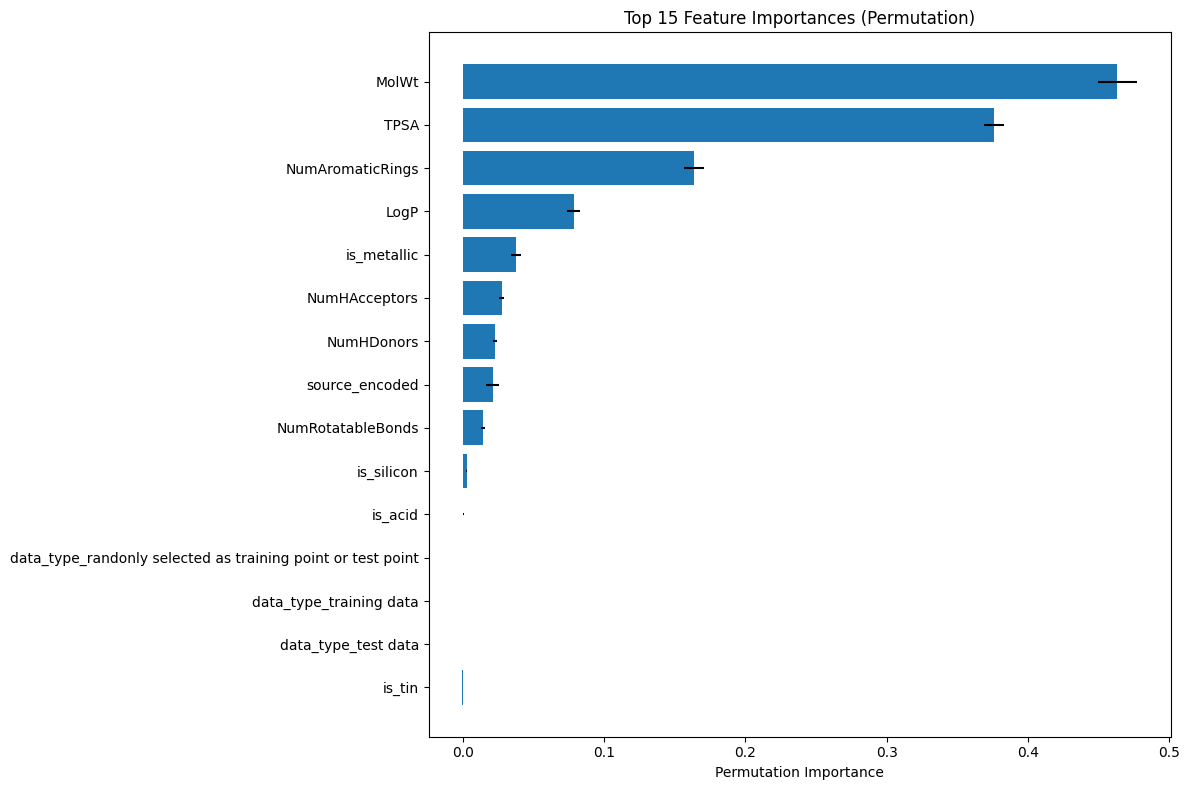

In [7]:
# Feature Importance Analysis - Method 2: Permutation Importance
print("Calculating permutation importance (this may take a few minutes)...")
perm_importance = permutation_importance(
    rf_model, X_test, y_test, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

# Create dataframe for permutation importance
perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 15 Most Important Features (Permutation Importance):")
print(perm_importance_df.head(15))

# Plot permutation importance with error bars
plt.figure(figsize=(12, 8))
top_perm_features = perm_importance_df.head(15)
plt.barh(range(len(top_perm_features)), top_perm_features['importance_mean'],
         xerr=top_perm_features['importance_std'])
plt.yticks(range(len(top_perm_features)), top_perm_features['feature'])
plt.xlabel('Permutation Importance')
plt.title('Top 15 Feature Importances (Permutation)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
def select_features_by_importance(importance_df, threshold=0.01):
    """Select features above a certain importance threshold"""
    selected_features = importance_df[importance_df['importance'] >= threshold]['feature'].tolist()
    return selected_features


rf_threshold = 0.01  
perm_threshold = 0.001 

# Select features using Random Forest importance
rf_selected = select_features_by_importance(feature_importance, rf_threshold)
print(f"Features selected by Random Forest importance (>= {rf_threshold}): {len(rf_selected)}")
print(f"Selected features: {rf_selected}")

# Select features using Permutation importance
perm_selected = perm_importance_df[perm_importance_df['importance_mean'] >= perm_threshold]['feature'].tolist()
print(f"\nFeatures selected by Permutation importance (>= {perm_threshold}): {len(perm_selected)}")
print(f"Selected features: {perm_selected}")

# Find common important features between both methods
common_features = list(set(rf_selected) & set(perm_selected))
print(f"\nCommon important features between both methods: {len(common_features)}")
print(f"Common features: {common_features}")

Features selected by Random Forest importance (>= 0.01): 9
Selected features: ['MolWt', 'TPSA', 'NumAromaticRings', 'LogP', 'is_metallic', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'source_encoded']

Features selected by Permutation importance (>= 0.001): 10
Selected features: ['MolWt', 'TPSA', 'NumAromaticRings', 'LogP', 'is_metallic', 'NumHAcceptors', 'NumHDonors', 'source_encoded', 'NumRotatableBonds', 'is_silicon']

Common important features between both methods: 9
Common features: ['NumAromaticRings', 'source_encoded', 'is_metallic', 'TPSA', 'NumHDonors', 'LogP', 'NumHAcceptors', 'MolWt', 'NumRotatableBonds']


In [15]:
# Calculate bias: average of prediction error
bias = np.mean(y_test_pred - y_test)
print(f"Bias: {bias:.4f}")


Bias: -1.0024


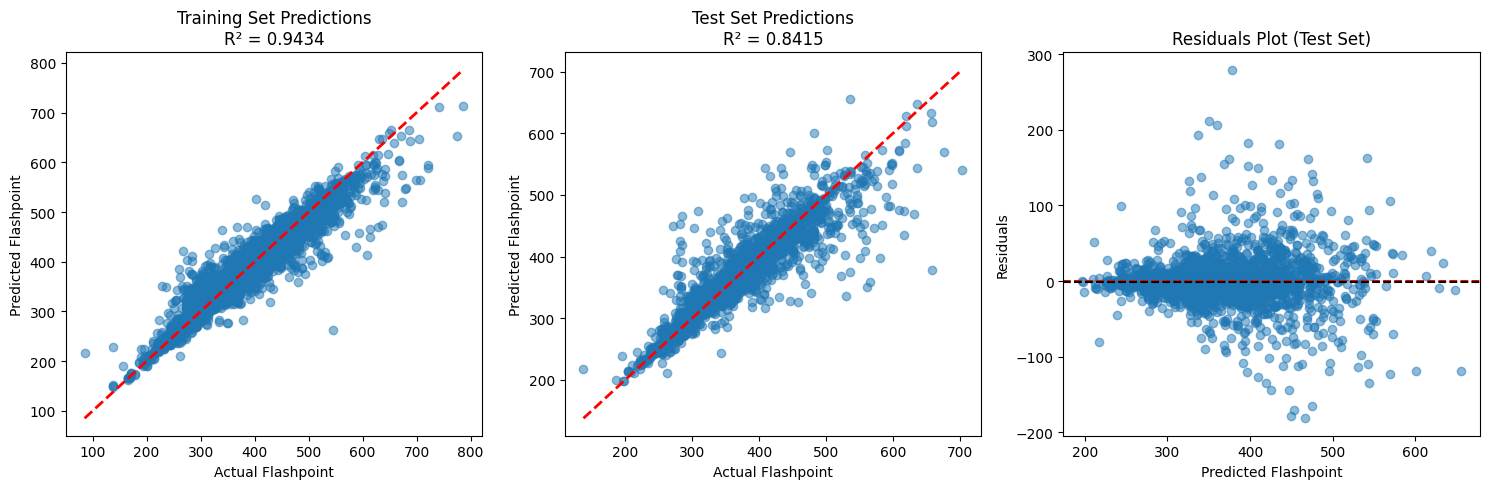

In [17]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 5))

# Training set predictions
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Flashpoint')
plt.ylabel('Predicted Flashpoint')
plt.title(f'Training Set Predictions\nR² = {train_metrics["R2"]:.4f}')

# Test set predictions
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Flashpoint')
plt.ylabel('Predicted Flashpoint')
plt.title(f'Test Set Predictions\nR² = {test_metrics["R2"]:.4f}')

# Residuals plot
plt.subplot(1, 3, 3)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=-1.0024, color='black', linestyle='--')  #bias line
plt.xlabel('Predicted Flashpoint')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Test Set)')

plt.tight_layout()
plt.show()

In [18]:
# Train a reduced model using only the most important features
print("Training a reduced model using only the most important features...")

# Use the top 10 features from Random Forest importance
top_features_rf = feature_importance.head(10)['feature'].tolist()
X_train_reduced = X_train[top_features_rf]
X_test_reduced = X_test[top_features_rf]

# Train reduced model
rf_reduced = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_reduced.fit(X_train_reduced, y_train)

# Make predictions with reduced model
y_train_pred_reduced = rf_reduced.predict(X_train_reduced)
y_test_pred_reduced = rf_reduced.predict(X_test_reduced)

# Evaluate reduced model
print("\n=== REDUCED MODEL PERFORMANCE (Top 10 Features) ===")
train_metrics_reduced = evaluate_model(y_train, y_train_pred_reduced, "Training Set (Reduced)")
test_metrics_reduced = evaluate_model(y_test, y_test_pred_reduced, "Test Set (Reduced)")

# Compare with full model
print("\n=== MODEL COMPARISON ===")
print(f"Full Model Test R²:    {test_metrics['R2']:.4f}")
print(f"Reduced Model Test R²: {test_metrics_reduced['R2']:.4f}")
print(f"Performance difference: {test_metrics_reduced['R2'] - test_metrics['R2']:.4f}")
print(f"Features reduced from {X_train.shape[1]} to {len(top_features_rf)} ({(1-len(top_features_rf)/X_train.shape[1])*100:.1f}% reduction)")

Training a reduced model using only the most important features...

=== REDUCED MODEL PERFORMANCE (Top 10 Features) ===

Training Set (Reduced) Performance:
  RMSE: 17.1732
  MAE:  9.5634
  R²:   0.9430

Test Set (Reduced) Performance:
  RMSE: 28.9969
  MAE:  16.0116
  R²:   0.8415

=== MODEL COMPARISON ===
Full Model Test R²:    0.8415
Reduced Model Test R²: 0.8415
Performance difference: -0.0000
Features reduced from 15 to 10 (33.3% reduction)

=== REDUCED MODEL PERFORMANCE (Top 10 Features) ===

Training Set (Reduced) Performance:
  RMSE: 17.1732
  MAE:  9.5634
  R²:   0.9430

Test Set (Reduced) Performance:
  RMSE: 28.9969
  MAE:  16.0116
  R²:   0.8415

=== MODEL COMPARISON ===
Full Model Test R²:    0.8415
Reduced Model Test R²: 0.8415
Performance difference: -0.0000
Features reduced from 15 to 10 (33.3% reduction)


In [ ]:
# Save the trained reduced model and feature info
import joblib
from datetime import datetime
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Get current timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("Saving reduced model...")

# Save the reduced Random Forest model
reduced_model_path = f"../models/rf_flashpoint_reduced_{timestamp}.pkl"
joblib.dump(rf_reduced, reduced_model_path)
print(f" Reduced model saved to: {reduced_model_path}")

# Save the feature lists and metadata
feature_info = {
    'top_features': top_features_rf,
    'all_features': list(X_train.columns),
    'feature_importance': feature_importance.to_dict('records'),
    'model_performance': {
        'reduced_model': test_metrics_reduced
    },
    'timestamp': timestamp
}

feature_info_path = f"../models/feature_info_{timestamp}.pkl"
joblib.dump(feature_info, feature_info_path)
print(f" Feature information saved to: {feature_info_path}")

# Also save latest versions
joblib.dump(rf_reduced, "../models/rf_flashpoint_reduced_latest.pkl")
joblib.dump(feature_info, "../models/feature_info_latest.pkl")

print(f"\n Reduced model and metadata saved in '../models/' directory")


Saving reduced model...
✅ Reduced model saved to: ../models/rf_flashpoint_reduced_20250612_145624.pkl
✅ Feature information saved to: ../models/feature_info_20250612_145624.pkl

📁 Reduced model and metadata saved in '../models/' directory
✅ Reduced model saved to: ../models/rf_flashpoint_reduced_20250612_145624.pkl
✅ Feature information saved to: ../models/feature_info_20250612_145624.pkl

📁 Reduced model and metadata saved in '../models/' directory
